## Cleaning Animals-10

In [1]:
import os
import glob
import pickle
import torch
import numpy as np
import pandas as pd
from torchvision import transforms
from skimage import io
from tqdm import tqdm

import matplotlib.pyplot as plt

### Loading the Dataset

In [2]:
def create_csv_files(root="./datasets/"):
    df_translate = pd.DataFrame.from_dict(
        {"cane": ["dog"], "cavallo": ["horse"], "elefante": ["elephant"], "farfalla": ["butterfly"], "gallina": ["chicken"],
        "gatto": ["cat"], "mucca": ["cow"], "pecora": ["sheep"], "ragno": ["spider"], "scoiattolo": ["squirrel"]})

    images = []
    labels = []
    for i, c in enumerate(df_translate):
        # img_paths = glob.glob(root + f"animals10/raw-img/{c}/*")
        img_paths = glob.glob(os.path.join(root, f"animals10/raw-img/{c}/*"))

        for img_path in img_paths:
            # img = img_path.replace(root+'animals10/', '').replace('\\', '/')
            img = img_path.replace(os.path.join(root, "animals10/"), '').replace('\\', '/')
            images.append(img)
            labels.append(i)

    df_animals10 = pd.DataFrame.from_dict({'image': images, 'label': labels})

    df_translate.to_csv(os.path.join(root, "animals10/translate.csv"), index=False)
    df_animals10.to_csv(os.path.join(root, "animals10/animals10.csv"), index=False)

In [3]:
root = "./datasets/"

if not os.path.isfile(os.path.join(root, "animals10/translate.csv")) or not os.path.isfile(os.path.join(root, "animals10/animals10.csv")):
    create_csv_files(root=root)

df_translate = pd.read_csv(os.path.join(root, "animals10/translate.csv"))
df_animals10 = pd.read_csv(os.path.join(root, "animals10/animals10.csv"))

classes = df_translate.columns.to_list()

In [4]:
data = []
targets = []
if os.path.isfile(os.path.join(root, f"animals10/{classes[0]}")):
    for i, c in enumerate(tqdm(classes)):
        file_name = f"{c}"
        file_path = os.path.join(root, "animals10/", file_name)

        with open(file_path, 'rb') as f:
            entry = pickle.load(f, encoding='latin1')
        data.extend(entry['data'])
        targets.extend(entry['labels'])
else:
    for i, c in enumerate(classes):
        data_c = []
        targets_c = []
        for idx in tqdm(df_animals10[df_animals10.label == i].index):
            img_path = os.path.join(root, "animals10/", df_animals10.iloc[idx,0])
            image = io.imread(img_path)/255.0
            data_c.append(image)
            targets_c.append(df_animals10.iloc[idx,1])

        data.extend(data_c)
        targets.extend(targets_c)

        file_name = f"{c}"
        file_path = os.path.join(root, "animals10/", file_name)

        entry = {'data': data_c, 'labels': targets_c}
        with open(file_path, 'wb') as f:
            pickle.dump(entry, f, protocol=-1)

100%|██████████| 10/10 [03:39<00:00, 21.97s/it]


### Investigating Image Shapes

Collect the different image shapes and store them in the dataFrame

In [5]:
shape_x = []
shape_y =[]

for image in tqdm(data):
    shape_x.append(image.shape[0])
    shape_y.append(image.shape[1])

df_animals10['shape_x'] = shape_x
df_animals10['shape_y'] = shape_y

  0%|          | 0/26179 [00:00<?, ?it/s]

100%|██████████| 26179/26179 [00:00<00:00, 280341.31it/s]


In [6]:
df_animals10

,image,label,shape_x,shape_y
0,raw-img/cane/OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg,0,225,300
1,raw-img/cane/OIP---A27bIBcUgX1qkbpZOPswHaFS.jpeg,0,214,300
2,raw-img/cane/OIP---ZIdwfUcJeVxnh47zppcQHaFj.jpeg,0,225,300
3,raw-img/cane/OIP---ZRsOF7zsMqhW30WeF8-AHaFj.jpeg,0,225,300
4,raw-img/cane/OIP---_cJbI6Ei26w5bW1urHewHaCf.jpeg,0,101,300
...,...,...,...,...
26174,raw-img/scoiattolo/OIP-zpD7SDCbIqwjYm2A06OybwH...,9,300,277
26175,raw-img/scoiattolo/OIP-zpZ5t_rN3DA6xByG0o05WwA...,9,201,300
26176,raw-img/scoiattolo/OIP-zwWLqRd95U-BjagmhkAgoQH...,9,209,300
26177,raw-img/scoiattolo/OIP-zyCc-DDxjCSB5m9DR3uNKQH...,9,200,300


#### Scatter Plot of the Image Shapes

Although the range of all shape is huge only on class has images with sizes larger than 1000.

<Axes: xlabel='shape_x', ylabel='shape_y'>

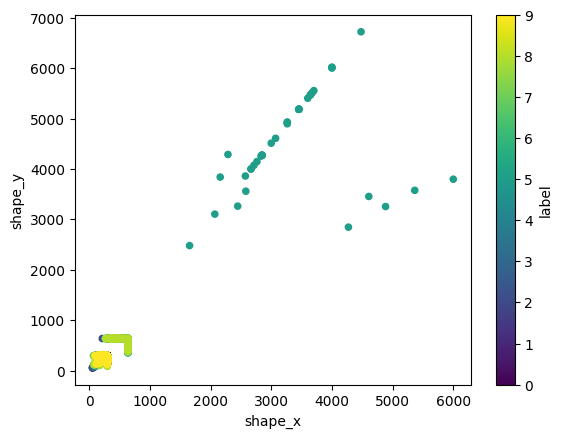

In [7]:
df_animals10.plot.scatter(x='shape_x', y='shape_y', c='label', colormap='viridis')

Excluding these large images one can see that only for sizes blow 300 all classes are represented.

<Axes: xlabel='shape_x', ylabel='shape_y'>

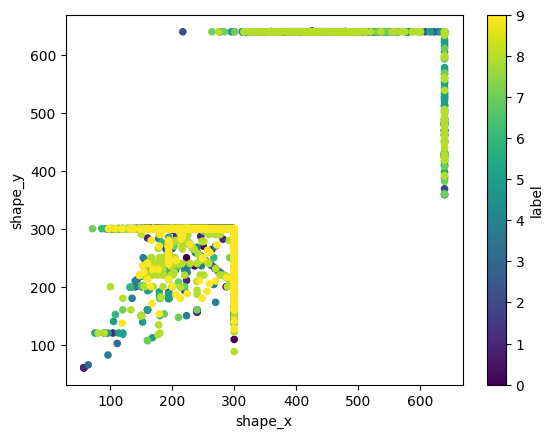

In [8]:
df_animals10[df_animals10.shape_x < 1000].plot.scatter(x='shape_x', y='shape_y', c='label', colormap='viridis')

### Reducing to Images of sizes 160 to 300

Now consider images with shapes between 160 and 300.

In [33]:
df_animals10_to300 = df_animals10[(df_animals10.shape_x <= 300) & (df_animals10.shape_y <= 300)]
df_animals10_160to300 = df_animals10_to300[(df_animals10_to300.shape_x >= 160) & (df_animals10_to300.shape_y >= 160)].copy()
df_animals10_160to300 = df_animals10_160to300.reset_index()
df_animals10_160to300

,index,image,label,shape_x,shape_y
0,0,raw-img/cane/OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg,0,225,300
1,1,raw-img/cane/OIP---A27bIBcUgX1qkbpZOPswHaFS.jpeg,0,214,300
2,2,raw-img/cane/OIP---ZIdwfUcJeVxnh47zppcQHaFj.jpeg,0,225,300
3,3,raw-img/cane/OIP---ZRsOF7zsMqhW30WeF8-AHaFj.jpeg,0,225,300
4,6,raw-img/cane/OIP--0C2kq6I68beB3DduLoxMgHaEf.jpeg,0,182,300
...,...,...,...,...,...
23569,26174,raw-img/scoiattolo/OIP-zpD7SDCbIqwjYm2A06OybwH...,9,300,277
23570,26175,raw-img/scoiattolo/OIP-zpZ5t_rN3DA6xByG0o05WwA...,9,201,300
23571,26176,raw-img/scoiattolo/OIP-zwWLqRd95U-BjagmhkAgoQH...,9,209,300
23572,26177,raw-img/scoiattolo/OIP-zyCc-DDxjCSB5m9DR3uNKQH...,9,200,300


Leading to this distribution of shapes for the images.

<Axes: xlabel='shape_x', ylabel='shape_y'>

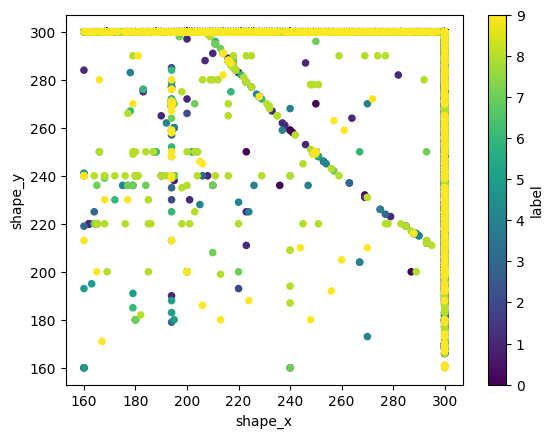

In [10]:
df_animals10_160to300.plot.scatter(x='shape_x', y='shape_y', c='label', colormap='viridis')

For the individual classes the shape distributions look similar enough.

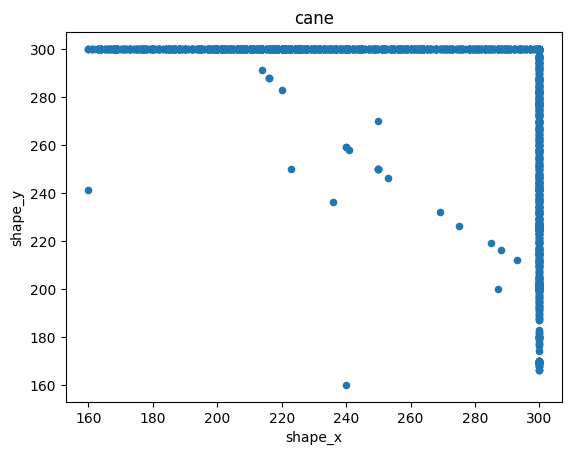

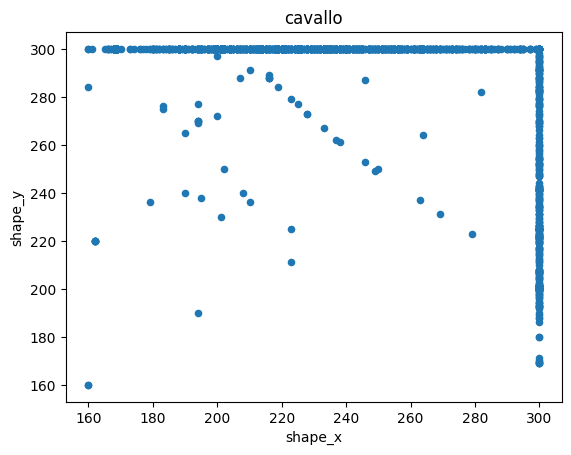

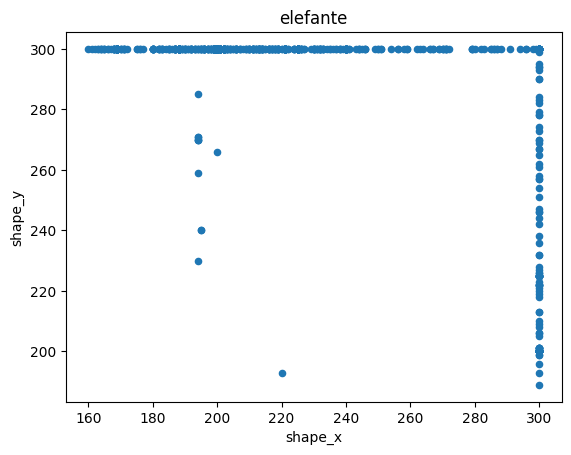

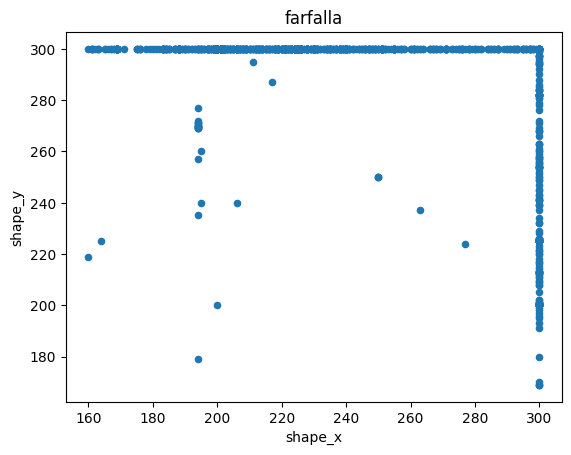

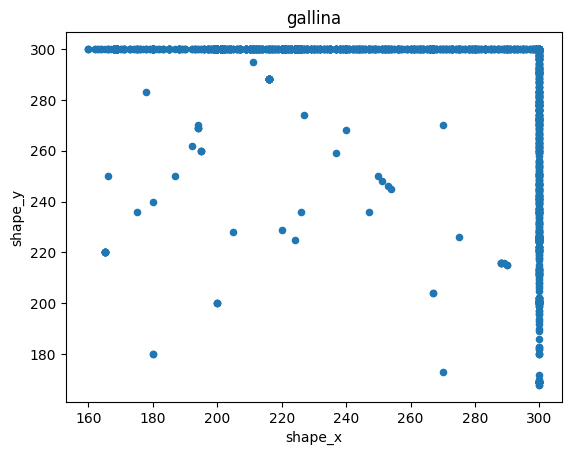

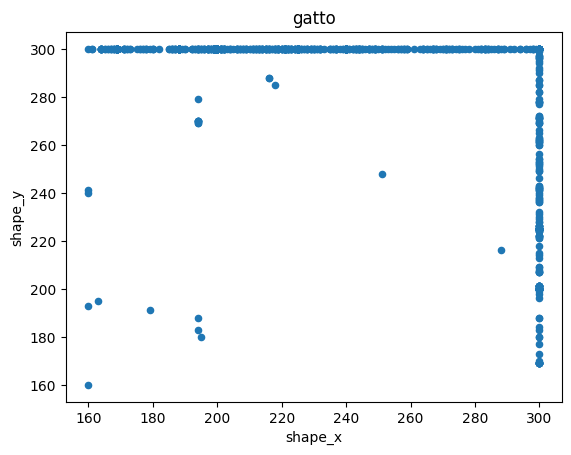

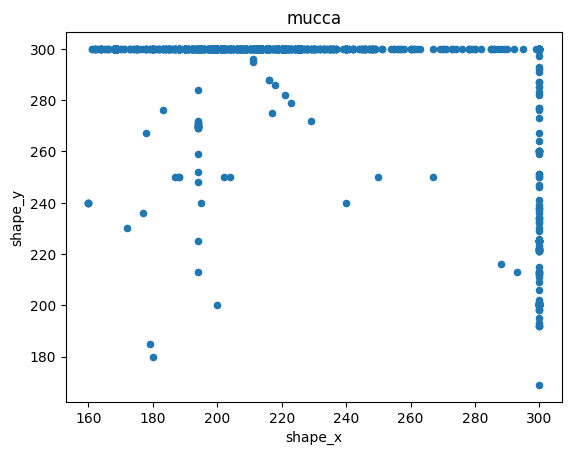

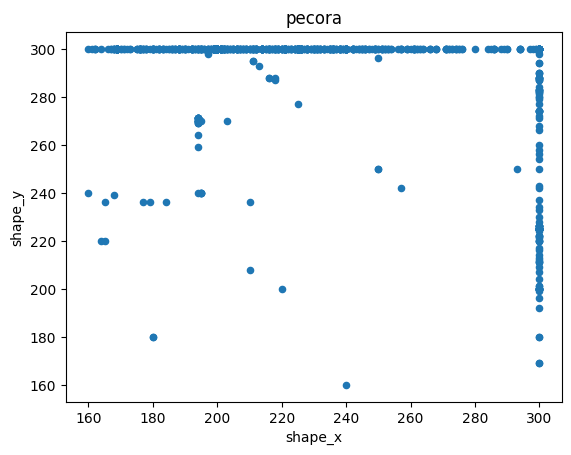

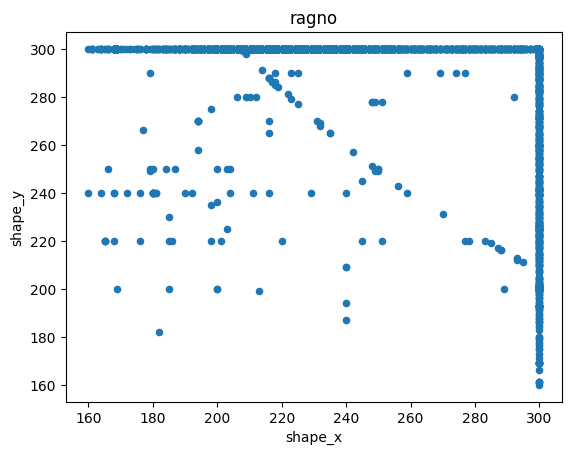

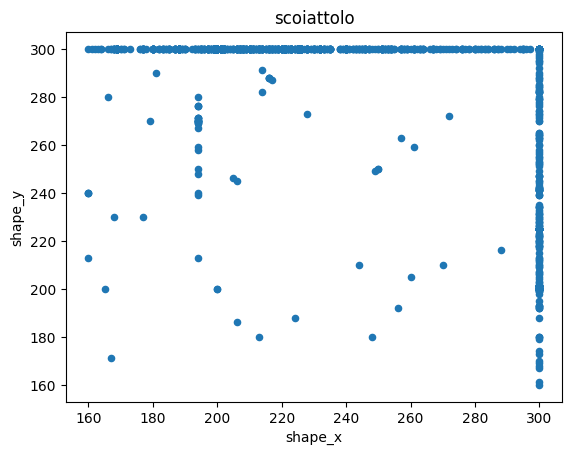

In [11]:
for l, c in enumerate(classes):
    df_animals10_160to300[df_animals10_160to300.label == l].plot.scatter(x='shape_x', y='shape_y', title=c)

This choice of image leads sadly to an slightly more unbalanced dataset.

<Axes: title={'center': 'shapes 160 to 300'}, xlabel='label'>

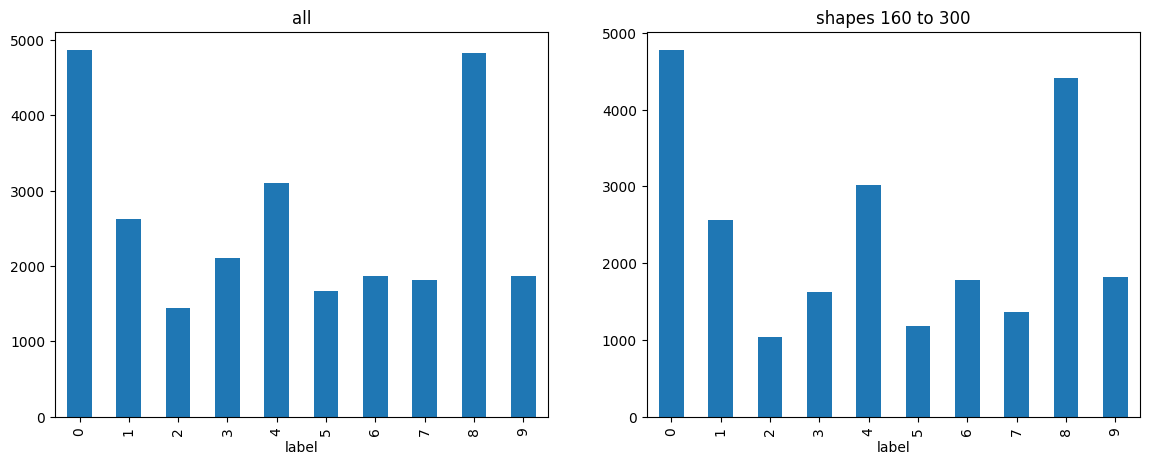

In [12]:
fig, axs = plt.subplots(ncols=2, figsize=(14, 5))

df_animals10.label.value_counts()[df_animals10_160to300.label.unique()].plot(kind='bar', title='all', ax=axs[0])
df_animals10_160to300.label.value_counts()[df_animals10_160to300.label.unique()].plot(kind='bar', title='shapes 160 to 300', ax=axs[1])

#### Store the reduced Dataset

Add padding so that all images are 300x300.

In [13]:
ds_name = "animals10_160to300"

data_160to300 = []
for idx in tqdm(df_animals10_160to300['index']):
    image = torch.Tensor(data[idx]).permute((2,0,1))

    padding = [(300-image.shape[2]+1)//2, (300-image.shape[1]+1)//2, (300-image.shape[2])//2, (300-image.shape[1])//2]
    image = transforms.functional.pad(image, padding=padding).permute((1,2,0)).numpy()

    data_160to300.append(image)

data_160to300 = np.array(data_160to300)

100%|██████████| 23574/23574 [04:20<00:00, 90.50it/s] 


Write with pickle

In [52]:
os.makedirs(os.path.join(root, ds_name), exist_ok=True)

for i, c in enumerate(tqdm(classes)):
    data_c = data_160to300[df_animals10_160to300[df_animals10_160to300.label == i].index]
    targets_c = df_animals10_160to300[df_animals10_160to300.label == i]['label'].to_list()

    file_name = f"{c}"
    file_path = os.path.join(root, ds_name, file_name)

    entry = {'data': data_c, 'labels': targets_c}
    with open(file_path, 'wb') as f:
        pickle.dump(entry, f, protocol=-1)

100%|██████████| 10/10 [01:38<00:00,  9.85s/it]


Write also the dataFrame as csv file.

In [53]:
df_translate.to_csv(os.path.join(root, ds_name, "translate.csv"), index=False)
df_animals10_160to300[['index', 'image', 'label']].to_csv(os.path.join(root, ds_name, "animals10_160to300.csv"), index=False)